# SET UP

In [2]:
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, plot_tree


In [3]:
# Configurations
pd.set_option('display.max_columns', None)

In [4]:
# Initialize dictionary of dataframes

adv_pass = {}
data = {}
years = [19, 20, 21, 22, 23, 24]


In [5]:
# Load CSVs per year

# NOTE: You can comment out a line if you already have the data and don't want to import it
for x in years:
    adv_pass[x] = pd.read_csv('data/passing_adv_20' + str(x) + '.csv')

print("done")


done


In [6]:
# Extract subsets of columns we want from CSVs into dataframes we will use for calculations

# TODO: rename these columns (e.g. 'name_display' to 'player', 'team_name_abbr' to 'tm', 'pass_cmp' to 'cmp', etc.)
for x in years:
    df = adv_pass[x]
    df = df[df['pass_att'] >= 250] # Drop passers who don't have at least 250 pass attempts
    data[x] = df[['name_display', 'team_name_abbr', 'pass_cmp', 'pass_att', 'pass_batted_passes', 'pass_throwaways', 'pass_spikes', 
                        'pass_drops', 'pass_poor_throws','pass_on_target', 'pocket_time', 'pass_blitzed', 'pass_hurried',
                        'pass_hits', 'pass_pressured', 'rush_scrambles']]
    


In [7]:
# Color Palette
# Map each team to its respective hex color

nfl_team_colors = {
    'ARI': '#97233F',  # Arizona Cardinals
    'ATL': '#A71930',  # Atlanta Falcons
    'BAL': '#241773',  # Baltimore Ravens
    'BUF': '#00338D',  # Buffalo Bills
    'CAR': '#0085CA',  # Carolina Panthers
    'CHI': '#0B162A',  # Chicago Bears
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'CLE': '#311D00',  # Cleveland Browns
    'DAL': '#003594',  # Dallas Cowboys
    'DEN': '#FB4F14',  # Denver Broncos
    'DET': '#0076B6',  # Detroit Lions
    'GNB':  '#203731',  # Green Bay Packers
    'HOU': '#03202F',  # Houston Texans
    'IND': '#002C5F',  # Indianapolis Colts
    'JAX': '#006778',  # Jacksonville Jaguars
    'KAN':  '#E31837',  # Kansas City Chiefs
    'LAC': '#0073CF',  # Los Angeles Chargers
    'LAR': '#003594',  # Los Angeles Rams
    'LVR':  '#000000',  # Las Vegas Raiders
    'MIA': '#008E97',  # Miami Dolphins
    'MIN': '#4F2683',  # Minnesota Vikings
    'NWE':  '#002244',  # New England Patriots
    'NOR':  '#D3BC8D',  # New Orleans Saints
    'NYG': '#0B2265',  # New York Giants
    'NYJ': '#125740',  # New York Jets
    'OAK' : '000000', # Oakland Raiders
    'PHI': '#004C54',  # Philadelphia Eagles
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'SEA': '#002244',  # Seattle Seahawks
    'SFO':  '#AA0000',  # San Francisco 49ers
    'TAM':  '#D50A0A',  # Tampa Bay Buccaneers
    'TEN': '#4B92DB',  # Tennessee Titans
    'WAS': '#5A1414'   # Washington Commanders
}


In [8]:
# Function which can graph any singular stat for any given dataframe

def statGrapher(df, stat, text = 'Stat', yr = 2024, pct = True):
    
    # Plot data by descending order of stat leader
    order_stat = df.sort_values(by=stat, ascending=False)['name_display']
    stat_ranked = df.sort_values(by=stat, ascending=False)[stat]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=stat, y='name_display', hue = 'team_name_abbr', data=df, 
                palette = nfl_team_colors, order = order_stat, dodge = False)
    
    plt.title(text + " in " + str(yr))
    plt.legend().remove()
    
    # Set x-axis and y-axis labels
    plt.xlabel(text)  # x-axis label
    plt.ylabel('Quarterback')  # y-axis label
    
    # Show actual stat on plot
    i = 0
    for x in stat_ranked.astype(float):
        if pct:
            plt.text(x, i, f"{x:.2f}" + "%", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        else:
             plt.text(x, i, f"{x:.2f}", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        i += 1
        
    center_position = (df.index.max() + df.index.min()) / 2

    # Add a horizontal line along the center
    plt.axhline(y = center_position, color='r', linestyle='--', linewidth=2)
    
    plt.show()


In [9]:
# Calcuate eval metrics based on given data

def calcEval(y, pred):
    r2 = r2_score(y, pred)
    print(f"R²: {r2}")

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, pred)
    print(f"Mean Absolute Error (MAE): {mae}")

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

In [10]:
# Consolildate year-by-year data into one big df (i.e. xCmp_data) and also include a season column

xCmp_data = pd.DataFrame()
xCmpOL_data = pd.DataFrame()

for x in years:
    df = data[x]
    df['Season'] = "20" + str(x)
    xCmp_data = pd.concat([xCmp_data, df], axis=0)
    xCmpOL_data = pd.concat([xCmpOL_data, df], axis=0)

# xCMP MODEL USING XGBoost

In [11]:
# Create X and y

X = xCmp_data[['pass_throwaways', 'pass_poor_throws', 'pass_on_target', 'pass_drops']]
y = xCmp_data[['pass_cmp']]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Implement PCA

In [13]:
# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Apply PCA
pca = PCA(n_components=0.95)  # preserve 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [15]:
# create xgb model

xgbCmp_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=99
)



In [16]:
xgbCmp_model.fit(X_train_pca, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [17]:
# Get predictions
y_pred = xgbCmp_model.predict(X_test_pca)

y_train_pred = xgbCmp_model.predict(X_train_pca)

In [18]:
# Evaluation Metrics for TESTING data

calcEval(y_test, y_pred)


R²: 0.9412736892700195
Mean Absolute Error (MAE): 12.939840316772461
Mean Squared Error (MSE): 278.63507080078125
Root Mean Squared Error (RMSE): 16.69236564423333


In [19]:
# Evaluation Metrics for TRAINING data

calcEval(y_train, y_train_pred)

R²: 0.9939855337142944
Mean Absolute Error (MAE): 4.81417179107666
Mean Squared Error (MSE): 41.31451416015625
Root Mean Squared Error (RMSE): 6.427636747682327


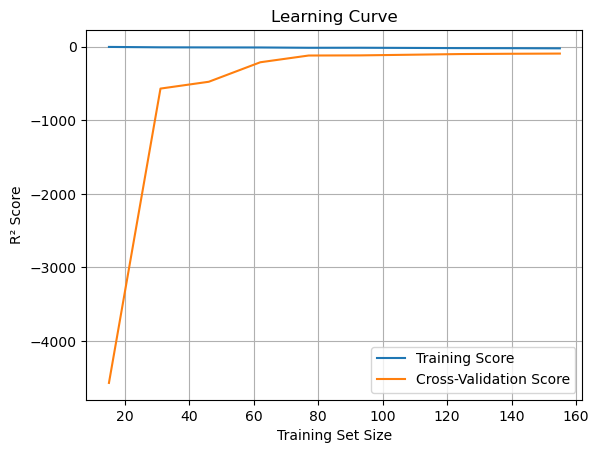

In [20]:
train_sizes, train_scores, test_scores = learning_curve(
    xgbCmp_model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("MSE Score")
plt.legend()
plt.title("Learning Curve")
plt.grid(True)
plt.show()

### Notes on Training vs Testing Eval Metrics

### Random State 99:

***Testing Stats:***

- R²: 0.9412736892700195
- Mean Absolute Error (MAE): 12.939840316772461
- Mean Squared Error (MSE): 278.63507080078125
- Root Mean Squared Error (RMSE): 16.69236564423333

***Training Stats:***

- R²: 0.9939855337142944
- Mean Absolute Error (MAE): 4.81417179107666
- Mean Squared Error (MSE): 41.31451416015625
- Root Mean Squared Error (RMSE): 6.427636747682327

The metrics have significantly worsened compared to the model without applying PCA. Moreover, the difference between training metrics and testing metrics is substantial.

### Analysis

PCA has possibly degraded the model. This is not surprising since tree models such as XGBoost do not need PCA, in fact PCA has been known to often degrade tree based models. The hope was PCA could reduce significant multicollineraity between the features, but this is clearly not the case.

##### Current Parameters
```
xgbCmp_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=99
)
```

##### Possible Improvements
- Figure out ways to reduce overfititng in XGBoost models in general (i.e. greater max_depth, n_estimators, etc.)
- Feature engineering

/opt/anaconda3/envs/footballXGB/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


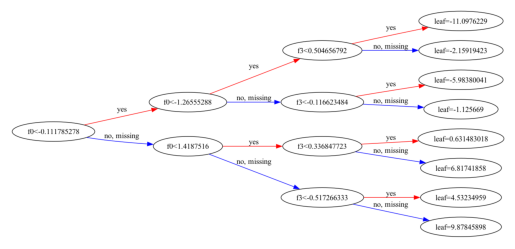

In [21]:
# Visualize xgb model

xgb.plot_tree(xgbCmp_model.get_booster(), num_trees=0,  rankdir='LR') 
plt.show()

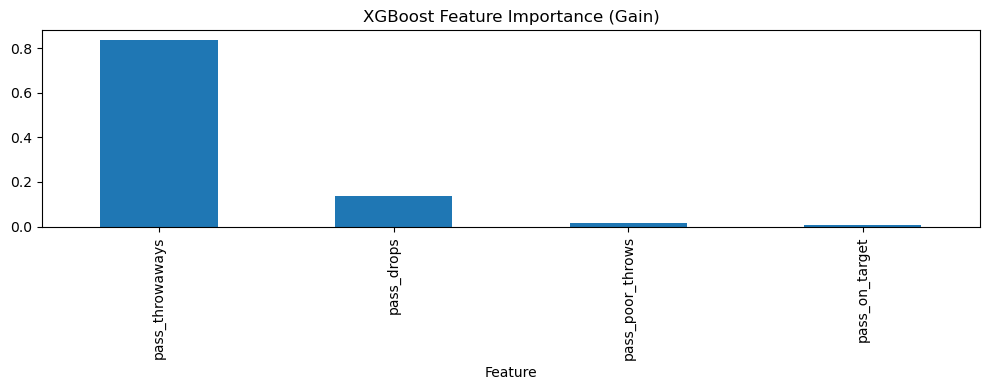

In [22]:
# Plot feature importance

importance = xgbCmp_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
importance_df.plot.bar(x='Feature', y='Importance', legend=False, figsize=(10, 4))
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

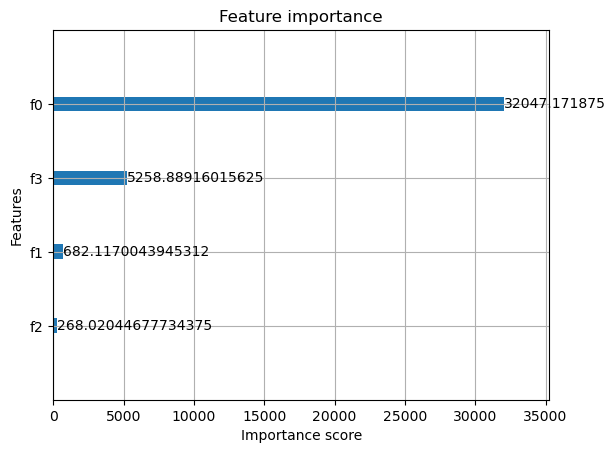

In [24]:
xgb.plot_importance(xgbCmp_model, importance_type='gain')  # options: 'weight', 'gain', 'cover'
plt.show()

# There is clearly one component that is significantly more influential than the other components

In [25]:
X.corr()['pass_on_target'].sort_values(ascending=False)


pass_on_target      1.000000
pass_poor_throws    0.721522
pass_drops          0.717985
pass_throwaways     0.411463
Name: pass_on_target, dtype: float64

### VISUALIZE xCMP

In [20]:
# Create new columns for visuals based on new data from the model


xCmp_data['cmpPct'] = (xCmp_data['pass_cmp']/xCmp_data['pass_att'])

xCmp_data['xAtt'] = xCmp_data['pass_att'] - xCmp_data['pass_spikes']

xCmp_data['xCmp'] = xgbCmp_model.predict(X)

xCmp_data['xCmpPct'] = (xCmp_data['xCmp']/xCmp_data['xAtt']) * 100

xCmp_data['xCmpPctDiff'] = (xCmp_data['xCmpPct'] - xCmp_data['cmpPct'])

xCmp_data['xCmpDiff'] = xCmp_data['xCmp'] - xCmp_data['pass_cmp'] 

In [38]:
# Filter data to 2024 stats

data24 = xCmp_data[xCmp_data['Season'] == "2024"]

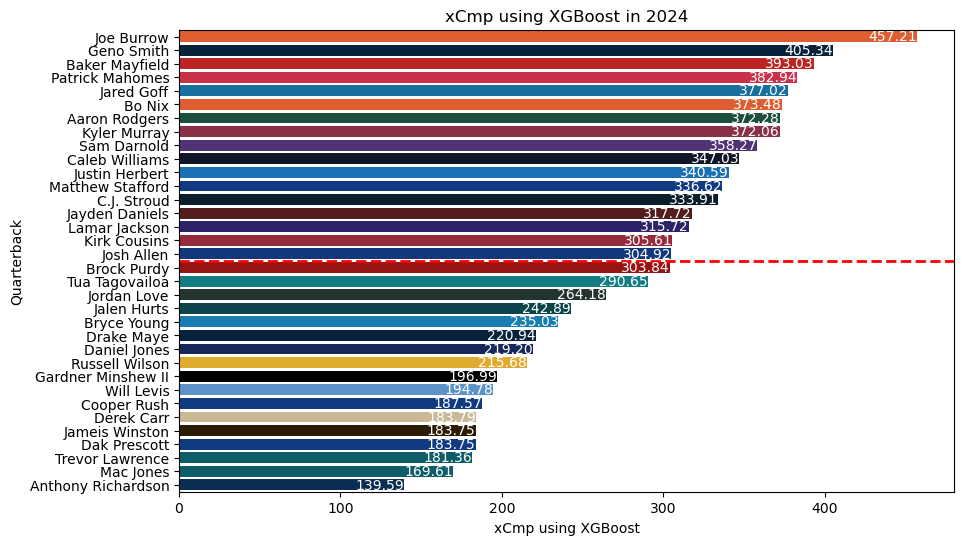

In [31]:
xCmp24_graph = statGrapher(data24, 'xCmp', 'xCmp using XGBoost', pct=False)

# Consider rounding/truncating decimals

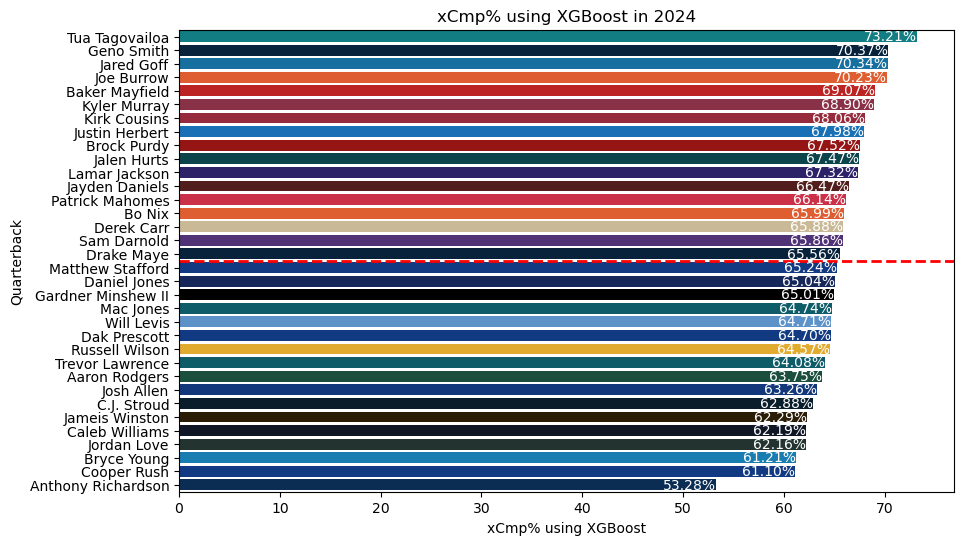

In [39]:
xCmpPct24_graph = statGrapher(data24, 'xCmpPct', 'xCmp% using XGBoost')

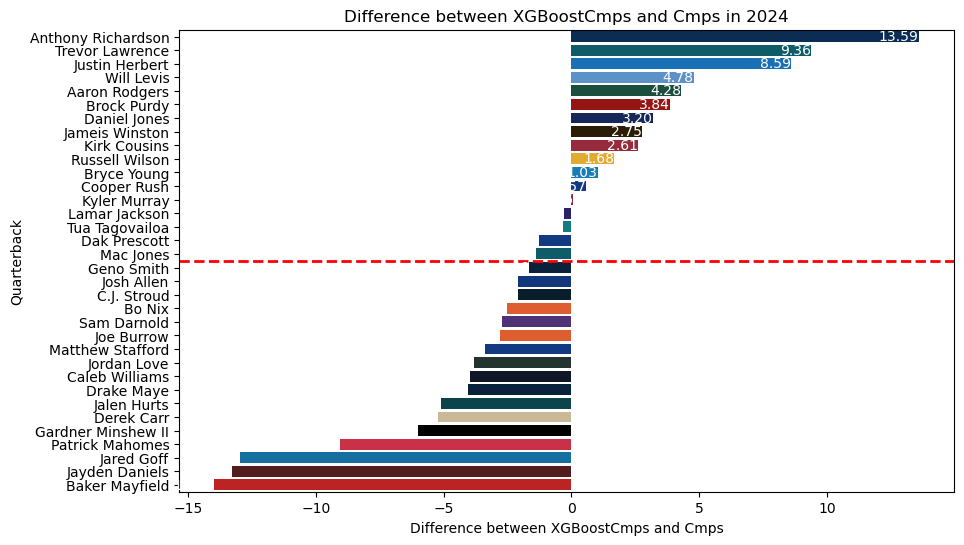

In [36]:
xCmp_diff_graph = statGrapher(data24, 'xCmpDiff', 'Difference between XGBoostCmps and Cmps', pct = False)


In [21]:
# 2024 xCmp% based on model

xCmpPct24_diff_graph = statGrapher(data24, 'xCmpPctDiff', 'Difference between XGBoostCmp% and Cmp%')

# NOTE: cmp% won't display for players with negative values because text is HA'd right & is white text

NameError: name 'data24' is not defined

# xCmp with OL Factors Model

Note: the way this model currently works is that actually rewards QBs whho's actual cmp% is better than their xCmp%. This is because a bad OL should lower their xCmp, so if a QB has more Cmp than their xCmp, it implies they did a good job of circumventing their OL. 

Since we want to make it seem like QBs who have more Cmp than xCmp are lucky rather than skilled, we want to reconfigure this model to reflect that philosophy. We need to find a way to somehow isolate OL-related features from the model while still finding a way to incorporate them into our xCmp calculations.

In [26]:
# Re-create X and y

X = xCmpOL_data[['pass_throwaways', 'pass_poor_throws', 'pass_on_target', 'pass_drops', 'pocket_time', 'pass_blitzed',
                'pass_pressured', 'rush_scrambles']]
y = xCmpOL_data[['pass_cmp']]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [28]:
# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# Apply PCA
pca = PCA(n_components=0.95)  # preserve 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [30]:
# create xgb model

xgbCmpOL_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=99
)


In [31]:
xgbCmpOL_model.fit(X_train_pca, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [32]:
# Get predictions
y_pred = xgbCmpOL_model.predict(X_test_pca)

y_train_pred = xgbCmpOL_model.predict(X_train_pca)

In [33]:
# Evaluation Metrics for TESTING data

calcEval(y_test, y_pred)


R²: 0.6198642253875732
Mean Absolute Error (MAE): 35.305789947509766
Mean Squared Error (MSE): 1803.607421875
Root Mean Squared Error (RMSE): 42.46889946625648


In [34]:
# Evaluation Metrics for TRAINING data

calcEval(y_train, y_train_pred)


R²: 0.9549562931060791
Mean Absolute Error (MAE): 13.471135139465332
Mean Squared Error (MSE): 309.4145812988281
Root Mean Squared Error (RMSE): 17.59018423152038


### Analysis on Eval Metrics

### Random State 99:

***Testing Stats:***

- R²: 0.6198642253875732
- Mean Absolute Error (MAE): 35.305789947509766
- Mean Squared Error (MSE): 1803.607421875
- Root Mean Squared Error (RMSE): 42.46889946625648

***Training Stats:***

- R²: 0.9549562931060791
- Mean Absolute Error (MAE): 13.471135139465332
- Mean Squared Error (MSE): 309.4145812988281
- Root Mean Squared Error (RMSE): 17.59018423152038

These numbers are pretty bad, especially regarding testing data. This suggests the model is especially overfitted as well as generally having a big margin of error.


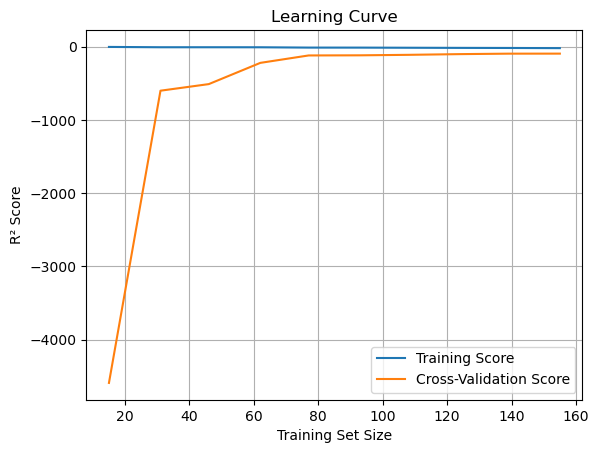

In [35]:
train_sizes, train_scores, test_scores = learning_curve(
    xgbCmpOL_model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("MSE Score")
plt.legend()
plt.title("Learning Curve")
plt.grid(True)
plt.show()

/opt/anaconda3/envs/footballXGB/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


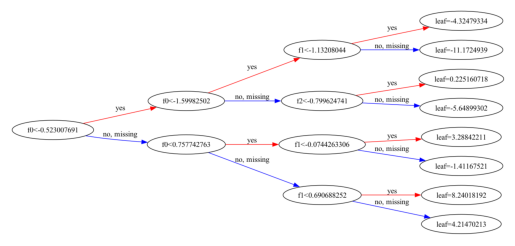

In [36]:
# Visualize new model with OL features

xgb.plot_tree(xgbCmpOL_model.get_booster(), num_trees=0,  rankdir='LR') 
plt.show()

In [37]:
# Plot feature importance

importance = xgbCmpOL_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
importance_df.plot.bar(x='Feature', y='Importance', legend=False, figsize=(10, 4))
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

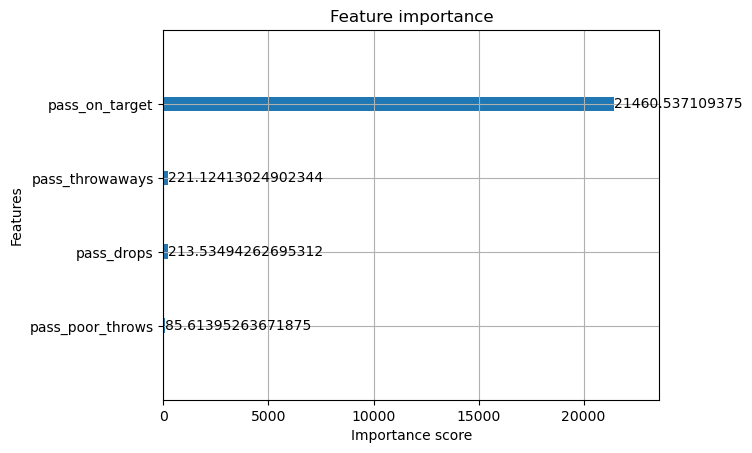

In [33]:
xgb.plot_importance(xgbCmp_model, importance_type='gain')  # options: 'weight', 'gain', 'cover'
plt.show()


### Visualize xCmpOL

In [31]:
# Create new columns for visuals based on new data from the model

# This time for xCmpOL_data

xCmpOL_data['cmpPct'] = (xCmpOL_data['pass_cmp']/xCmpOL_data['pass_att'])

xCmpOL_data['xAtt'] = xCmpOL_data['pass_att'] - xCmpOL_data['pass_spikes']

xCmpOL_data['xCmpOL'] = xgbCmpOL_model.predict(X)

xCmpOL_data['xCmpOLPct'] = (xCmpOL_data['xCmpOL']/xCmpOL_data['xAtt']) * 100

xCmpOL_data['xCmpOLPctDiff'] = (xCmpOL_data['xCmpOLPct'] - xCmpOL_data['cmpPct'])

xCmpOL_data['xCmpOLDiff'] = xCmpOL_data['xCmpOL'] - xCmpOL_data['pass_cmp'] 

In [32]:
# Filter data to 2024 stats

data24 = xCmpOL_data[xCmpOL_data['Season'] == "2024"]

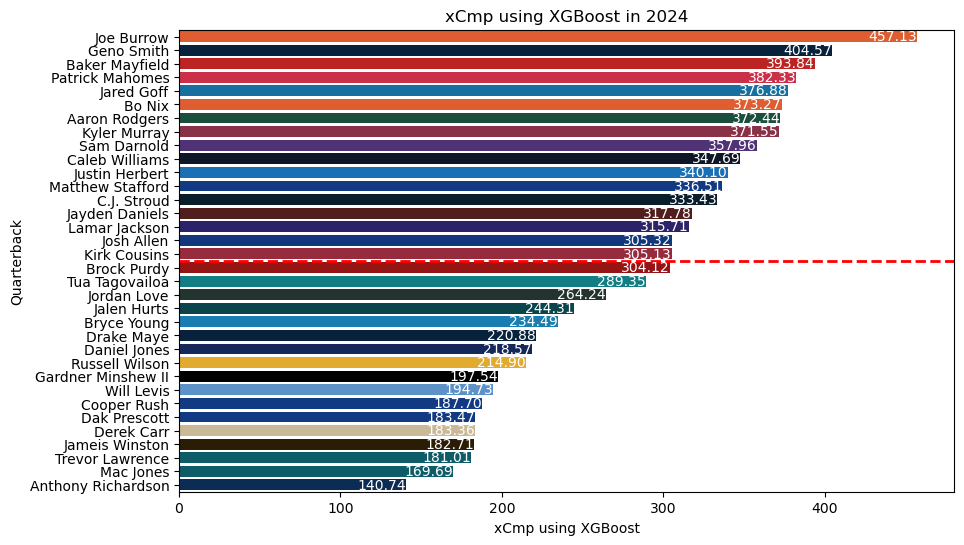

In [33]:
xCmpOL24_graph = statGrapher(data24, 'xCmpOL', 'xCmp using XGBoost', pct=False)

# Consider rounding/truncating decimals

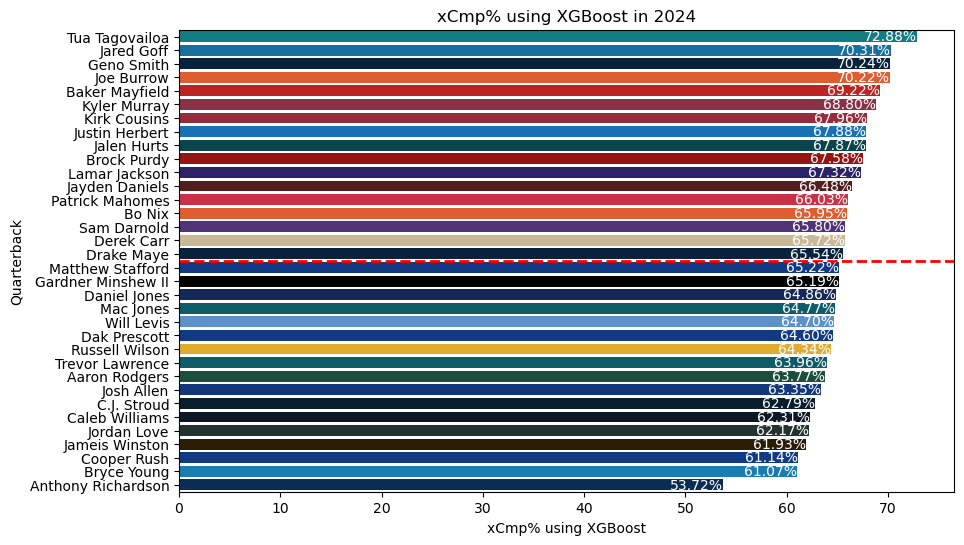

In [34]:
xCmpOLPct24_graph = statGrapher(data24, 'xCmpOLPct', 'xCmp% using XGBoost')

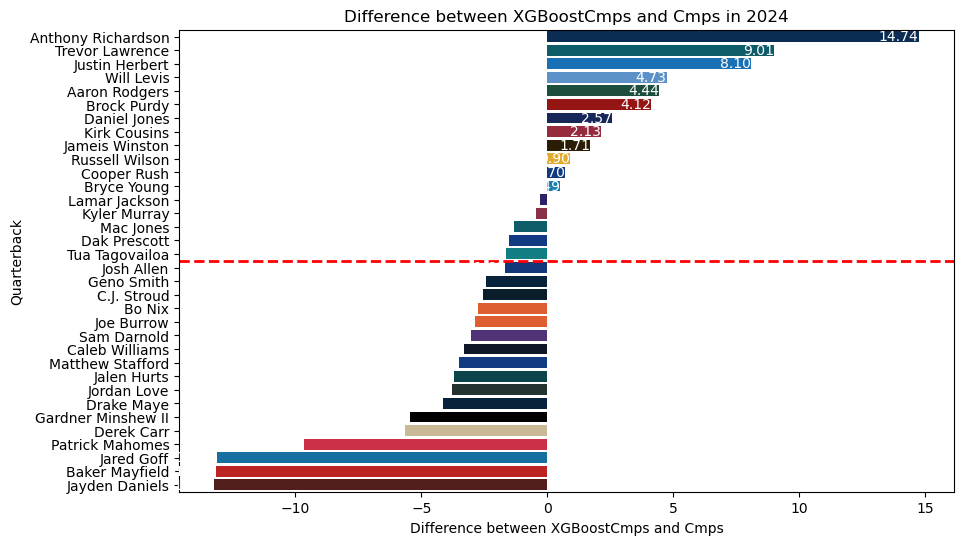

In [35]:
xCmpOL_diff_graph = statGrapher(data24, 'xCmpOLDiff', 'Difference between XGBoostCmps and Cmps', pct = False)


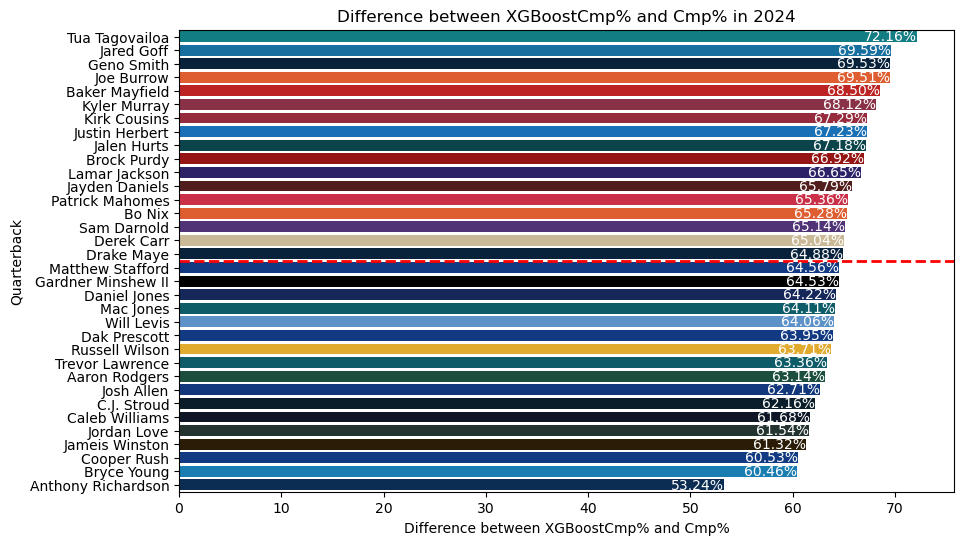

In [36]:
# 2024 xCmp% based on model

xCmpOLPct24_diff_graph = statGrapher(data24, 'xCmpOLPctDiff', 'Difference between XGBoostCmp% and Cmp%')

# NOTE: cmp% won't display for players with negative values because text is HA'd right & is white text

# EXPORTING NEW DATAFRAMES

In [2]:
# Export dfs to CSVs

# TODO: Find way to separate xCmp_data by year and export data per season to a unique CSV
xCmp_data.to_csv('data/xCmp_data/xCmp_passing.csv', index=False)

xCmpOL_data.to_csv('data/xCmp_data/xCmpOL_passing.csv', index=False)

'''
for x in years:
    df = data[x]
    df.to_csv('data/xCmp_data/xCmp_passing_20' + str(x) + '.csv', index=False)
'''

"\nfor x in years:\n    df = data[x]\n    df.to_csv('data/xCmp_data/xCmp_passing_20' + str(x) + '.csv', index=False)\n"